<a href="https://colab.research.google.com/github/emadphysics/Divulging-electricity-consumption-patterns/blob/main/Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

import zipfile
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import math
import seaborn as sns
from matplotlib import rcParams
from datetime import date

from pandas.tseries.holiday import AbstractHolidayCalendar
import pandas as pd

plt.style.use('bmh')
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Electricity loading**

In [ ]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from zipfile import ZipFile

zip_file = ZipFile('/content/gdrive/My Drive/archive (1).zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename),usecols=['start','load'],parse_dates=['start'],index_col=['start'])
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}

In [ ]:
data=pd.DataFrame(dfs['nl.csv'])
data=data.resample('H').sum()

In [ ]:
data

,load
start,
2015-01-01 00:00:00+00:00,37824.0
2015-01-01 01:00:00+00:00,35827.0
2015-01-01 02:00:00+00:00,33846.0
2015-01-01 03:00:00+00:00,32624.0
2015-01-01 04:00:00+00:00,32504.0
...,...
2020-07-31 19:00:00+00:00,51383.0
2020-07-31 20:00:00+00:00,50887.0
2020-07-31 21:00:00+00:00,48864.0


In [ ]:
data=data[(data.index>='2015-01-01')&(data.index<'2020-01-01')]

In [ ]:
weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}
data['Dates']=data.index.date
data['hour']=data.index.hour
data['year']=data.index.year
data['month']=data.index.month
data['day']=data.index.day
data['hour']=data.index.hour
data['weekday'] = data.index.weekday.map(weekdays)
data.index.names=['Date']
#data.index = data.index.map(lambda ts: ts.strftime("%Y-%m-%d"))

In [ ]:
hour_dict = {'morning': list(np.arange(7,13)),'afternoon': list(np.arange(13,16)), 'evening': list(np.arange(16,22)),
            'night': [22, 23, 0, 1, 2, 3, 4, 5, 6]}

In [ ]:
def daytime(x):
    if x in hour_dict['morning']:
        return 'morning'
    elif x in hour_dict['afternoon']:
        return 'afternoon'
    elif x in hour_dict['evening']:
        return 'evening'
    else:
        return 'night'

In [ ]:
data['daytime'] = data['hour'].apply(daytime)

In [ ]:
#!pip install workalendar
from pandas.tseries.holiday import *

In [ ]:
#subclassing to build the Netherlands public halidays
class Nl(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1),
        Holiday('Good Friday', month=4, day=10),
        Holiday('Easter Sunday', month=4, day=12),
        Holiday('Easter Monday', month=4, day=13),
        Holiday('Liberation Day', month=5, day=5),
        Holiday('Ascension Day', month=5, day=21),
        Holiday('Whitsun', month=5, day=31),
        Holiday('Whit Monday', month=6, day=1),
        Holiday('Christmas Day', month=12, day=25),
        Holiday('Christmas Day', month=12, day=26)
    ]

In [ ]:
cal = Nl()
holidays = cal.holidays(data.index.min(), data.index.max())
data['holiday'] = data.index.isin(holidays)
data['non_working'] = data.apply(lambda x: 'Yes' if \
                                         ((x['holiday'] == 1) or (x['weekday'] in ['Saturday', 'Sunday']))
                                         else 'No', axis = 1)
mapped = {True:1, False:0}
data['holiday'] = data['holiday'].map(mapped)
data.head()

,load,Dates,hour,year,month,day,weekday,daytime,holiday,non_working
Date,,,,,,,,,,
2015-01-01 00:00:00+00:00,37824.0,2015-01-01,0,2015,1,1,Thursday,night,1,Yes
2015-01-01 01:00:00+00:00,35827.0,2015-01-01,1,2015,1,1,Thursday,night,0,No
2015-01-01 02:00:00+00:00,33846.0,2015-01-01,2,2015,1,1,Thursday,night,0,No
2015-01-01 03:00:00+00:00,32624.0,2015-01-01,3,2015,1,1,Thursday,night,0,No
2015-01-01 04:00:00+00:00,32504.0,2015-01-01,4,2015,1,1,Thursday,night,0,No


In [ ]:
data['load'].kurt(),data['load'].skew()

(-0.6860683508134033, 0.07107788096585171)

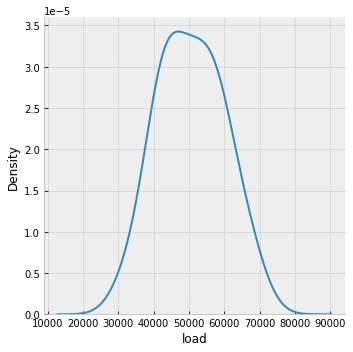

In [ ]:
sns.displot(data,x='load',kind="kde",bw_adjust=4)

In [ ]:
data['load'].describe()

count    43824.000000
mean     50585.174174
std       9334.947133
min      26001.000000
25%      43177.750000
50%      50431.500000
75%      57667.250000
max      77088.000000
Name: load, dtype: float64

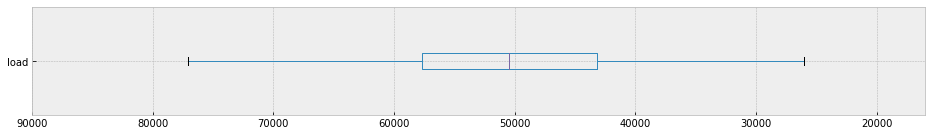

In [ ]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
data['load'].plot(kind='box', xlim=(90000, 16000), vert=False, flierprops=red_square, figsize=(16,2))

Fortunately, it does not suffers from outliers

In [ ]:
def season_calc(month):
    """adding season based on the data on SDGE's site -> https://www.sdge.com/whenmatters#how-it-works; 
       months from June to October are denoted as 'summer' and months from November to May as 'winter'. """
    if month in [1,2,3]:
      return "winter"
    elif month in [4,5,6]:
      return 'spring'
    elif month in [7,8,9]:
      return 'summer'
    else:
      return 'autumn'


In [ ]:
data['Dates'] = pd.to_datetime(data['Dates'])
data['season'] = data['Dates'].dt.month.apply(season_calc)

In [ ]:
data

,load,Dates,hour,year,month,day,weekday,daytime,holiday,non_working,season
Date,,,,,,,,,,,
2015-01-01 00:00:00+00:00,37824.0,2015-01-01,0,2015,1,1,Thursday,night,1,Yes,winter
2015-01-01 01:00:00+00:00,35827.0,2015-01-01,1,2015,1,1,Thursday,night,0,No,winter
2015-01-01 02:00:00+00:00,33846.0,2015-01-01,2,2015,1,1,Thursday,night,0,No,winter
2015-01-01 03:00:00+00:00,32624.0,2015-01-01,3,2015,1,1,Thursday,night,0,No,winter
2015-01-01 04:00:00+00:00,32504.0,2015-01-01,4,2015,1,1,Thursday,night,0,No,winter
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+00:00,51197.0,2019-12-31,19,2019,12,31,Tuesday,evening,0,No,autumn
2019-12-31 20:00:00+00:00,48257.0,2019-12-31,20,2019,12,31,Tuesday,evening,0,No,autumn
2019-12-31 21:00:00+00:00,46565.0,2019-12-31,21,2019,12,31,Tuesday,evening,0,No,autumn


# **Weather**

In [ ]:
weather=pd.read_csv('/content/gdrive/My Drive/KNMI.txt',usecols=['YYYYMMDD','# STN','   TG', '   SP','   NG'],error_bad_lines=False,header=0,parse_dates=['YYYYMMDD'])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (0,11,19,34) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
del weather['# STN']
weather.columns=['Date','temp','sunshine','cloudy']

In [ ]:
weather.max()

Date   2020-08-17
dtype: datetime64[ns]

In [ ]:
weather.drop_duplicates(subset='Date',inplace=True)

In [ ]:
weather.set_index('Date',inplace=True)

In [ ]:
categorical = [var for var in weather.columns if weather[var].dtype=='O']
for t in categorical:
    weather[t] = pd.to_numeric(weather[t],errors='coerce')

In [ ]:
weather['temp']=weather['temp']/10

In [ ]:
weather.dropna(inplace=True)

In [ ]:
weather=weather[(weather.index>='2015-01-01')&(weather.index<'2020-01-01')]

In [ ]:
weather

,temp,sunshine,cloudy
Date,,,
2015-01-01,4.0,15.0,5.0
2015-01-02,7.8,55.0,5.0
2015-01-03,5.3,0.0,7.0
2015-01-04,4.4,57.0,2.0
2015-01-05,3.4,10.0,7.0
...,...,...,...
2019-12-27,5.5,0.0,8.0
2019-12-28,1.9,69.0,8.0
2019-12-29,1.1,39.0,8.0


In [ ]:
for t in weather.columns:
    col_median=weather[t].median()
    weather[t]=weather[t].fillna(col_median)

In [ ]:
weather['temp'].skew(),weather['sunshine'].skew(),weather['cloudy'].skew()

(-0.026503386381451804, -0.21383422055834134, -0.8982553897277201)

In [ ]:
weather['temp'].kurt(),weather['sunshine'].kurt(),weather['cloudy'].kurt()

(-0.7743254931948425, -1.1655931524607468, 0.13554111028903337)

In [ ]:
# to kill outlirs with respect to the distribution nature
class outlierkiller:
    def __init__(self,df,x):
        self.df=df
        self.x=x
    def nongausskiller(self):
        for t in self.x:
            IQR = self.df[t].quantile(0.75) - self.df[t].quantile(0.25)
            Lower_fence = self.df[t].quantile(0.25) - (IQR * 3)
            Upper_fence = self.df[t].quantile(0.75) + (IQR * 3)
            self.df.loc[self.df[t]>Upper_fence, t] = Upper_fence
            self.df.loc[self.df[t]<Lower_fence, t] = Lower_fence
            return self
    def gausskiller(self):
        for t in self.x:
            Upper_boundary = self.df[t].mean() + 3* self.df[t].std()
            Lower_boundary = self.df[t].mean() - 3* self.df[t].std()
            self.df.loc[self.df[t]>Upper_boundary, t] = Upper_boundary
            self.df.loc[self.df[t]<Lower_boundary, t] = Lower_boundary
            return self
outlierkiller(weather,['cloudy','temp']).nongausskiller()
outlierkiller(weather,['sunshine']).gausskiller()


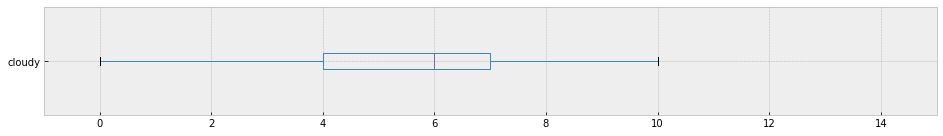

In [ ]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
weather['cloudy'].plot(kind='box', xlim=(-1, 15), vert=False, flierprops=red_square, figsize=(16,2))

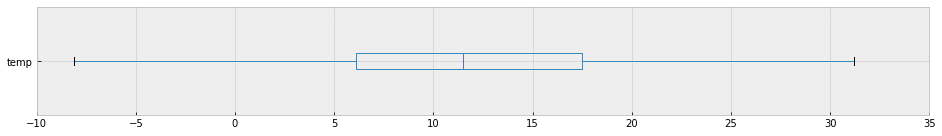

In [ ]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
weather['temp'].plot(kind='box', xlim=(-10, 35), vert=False, flierprops=red_square, figsize=(16,2))

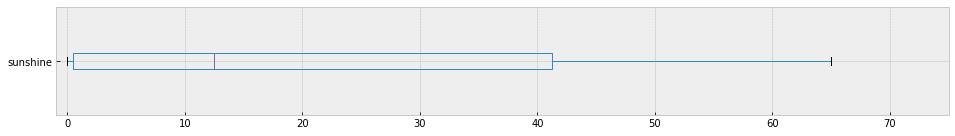

In [ ]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
weather['sunshine'].plot(kind='box', xlim=(-10, 200), vert=False, flierprops=red_square, figsize=(16,2))

In [ ]:
weather,data

(            temp  sunshine  cloudy
 Date                              
 2015-01-01   4.0      15.0     5.0
 2015-01-02   7.8      55.0     5.0
 2015-01-04   4.4      57.0     2.0
 2015-01-06   3.4      24.0     8.0
 2015-01-07   4.6      65.0     5.0
 ...          ...       ...     ...
 2019-06-25  28.5      64.0     6.0
 2019-07-24  29.4      88.0     6.0
 2019-07-25  30.3      82.0     6.0
 2019-07-26  29.6      58.0     6.0
 2019-08-28  23.6      54.0     6.0
 
 [19329 rows x 3 columns],
                  load      Dates  year  ...  holiday  Working Day  season
 Date                                    ...                              
 2015-01-01   987475.0 2015-01-01  2015  ...        0            1  winter
 2015-01-02  1145403.0 2015-01-02  2015  ...        0            1  winter
 2015-01-03  1240354.0 2015-01-03  2015  ...        0            0  winter
 2015-01-04  1202815.0 2015-01-04  2015  ...        0            0  winter
 2015-01-05  1508716.0 2015-01-05  2015  ...        0

In [ ]:
df=pd.merge(data, weather, left_index=True, right_index=True)

In [ ]:
df[df.isna().any(axis = 1)].sum()

load           0.0
Dates          0.0
year           0.0
month          0.0
day            0.0
hour           0.0
weekday        0.0
holiday        0.0
Working Day    0.0
season         0.0
temp           0.0
sunshine       0.0
cloudy         0.0
dtype: float64

In [ ]:
drive.mount('drive')

Mounted at drive


In [ ]:
df.to_csv('Wload.csv')
!cp Wload.csv "drive/My Drive/"
usecols=['YYYYMMDD','# STN','   TG', '   SP','   NG'],
,header=0,parse_dates=['YYYYMMDD']

In [ ]:
os.listdir(os.getcwd())

['.config',
 'Wload.csv',
 'load_n_weather.csv',
 'gdrive',
 'drive',
 'loadnweather.csv',
 'sample_data']

# ***WEATHER hourly***

In [ ]:
wdf=pd.read_csv('/content/gdrive/My Drive/NL_temp.csv',usecols=['utc_timestamp','NL_temperature'],error_bad_lines=False,header=0,parse_dates=['utc_timestamp'],index_col=['utc_timestamp'])

In [ ]:
wdf.index.names=['Date']

In [ ]:
wdf=wdf[(wdf.index>='2015-01-01')&(wdf.index<'2020-01-01')]

In [ ]:
wdf.isnull().sum()

NL_temperature    0
dtype: int64

In [ ]:
wdf['NL_temperature'].kurt(),wdf['NL_temperature'].skew()

(-0.6018359846360974, 0.166327603391475)

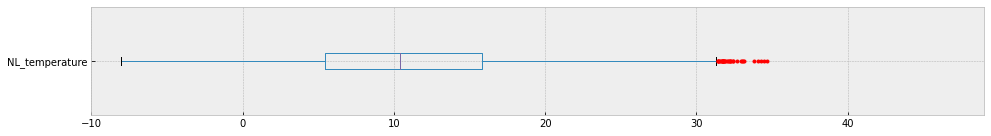

In [ ]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
wdf['NL_temperature'].plot(kind='box', xlim=(-10, 49), vert=False, flierprops=red_square, figsize=(16,2))

In [ ]:
# to kill outlirs with respect to the distribution nature
class outlierkiller:
    def __init__(self,df,x):
        self.df=df
        self.x=x
    def nongausskiller(self):
        for t in self.x:
            IQR = self.df[t].quantile(0.75) - self.df[t].quantile(0.25)
            Lower_fence = self.df[t].quantile(0.25) - (IQR * 3)
            Upper_fence = self.df[t].quantile(0.75) + (IQR * 3)
            self.df.loc[self.df[t]>Upper_fence, t] = Upper_fence
            self.df.loc[self.df[t]<Lower_fence, t] = Lower_fence
            return self
    def gausskiller(self):
        for t in self.x:
            Upper_boundary = self.df[t].mean() + 3* self.df[t].std()
            Lower_boundary = self.df[t].mean() - 3* self.df[t].std()
            self.df.loc[self.df[t]>Upper_boundary, t] = Upper_boundary
            self.df.loc[self.df[t]<Lower_boundary, t] = Lower_boundary
            return self
outlierkiller(wdf,['NL_temperature']).gausskiller()



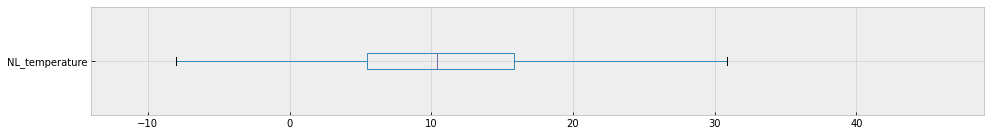

In [ ]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
wdf['NL_temperature'].plot(kind='box', xlim=(-14, 49), vert=False, flierprops=red_square, figsize=(16,2))

In [ ]:
wdf.columns=['temp']

In [ ]:
frame=pd.merge(data, wdf, left_index=True, right_index=True)

In [ ]:
drive.mount('drive')

Mounted at drive


In [ ]:
frame.to_csv('frame.csv')
!cp frame.csv "drive/My Drive/"


In [ ]:
frame

,load,Dates,hour,year,month,day,weekday,daytime,holiday,non_working,season,temp
Date,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,37824.0,2015-01-01,0,2015,1,1,Thursday,night,1,Yes,winter,1.869
2015-01-01 01:00:00+00:00,35827.0,2015-01-01,1,2015,1,1,Thursday,night,0,No,winter,1.625
2015-01-01 02:00:00+00:00,33846.0,2015-01-01,2,2015,1,1,Thursday,night,0,No,winter,1.448
2015-01-01 03:00:00+00:00,32624.0,2015-01-01,3,2015,1,1,Thursday,night,0,No,winter,1.250
2015-01-01 04:00:00+00:00,32504.0,2015-01-01,4,2015,1,1,Thursday,night,0,No,winter,1.102
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+00:00,51197.0,2019-12-31,19,2019,12,31,Tuesday,evening,0,No,autumn,2.909
2019-12-31 20:00:00+00:00,48257.0,2019-12-31,20,2019,12,31,Tuesday,evening,0,No,autumn,2.635
2019-12-31 21:00:00+00:00,46565.0,2019-12-31,21,2019,12,31,Tuesday,evening,0,No,autumn,2.210
